<a href="https://colab.research.google.com/github/Moostafaaa/Customer-Churn-Analysis-and-Prediction-using-PySpark/blob/main/Customer_Churn_Analysis_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Objective**

To develop a machine learning model using PySpark to predict customer churn within a telecommunications company. By analyzing customer data, the model will identify key factors contributing to churn and provide actionable insights to improve customer retention.

**Data Description**
The dataset contains customer-level information with each row representing a unique customer and each column representing a customer attribute. Key attributes include:

*   Customer demographics: gender, age range,
partner, dependents
*  Customer behavior: services subscribed (phone, multiple lines, internet, online security, online backup, device protection, tech support, streaming TV and movies), tenure, contract type, payment method, paperless billing, monthly charges, total charges.
*  Target variable: Churn (whether the customer left within the last month)



### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=967faf1a0c8380fc4ad5d87a1ea1c131b7f74ac19cf372a42493c055861d95ec
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Importing Modules

In [1]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [86]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [87]:
df = spark.read.csv('/content/dataset.csv',header=True, inferSchema=True)

Print the data schema to check out the data types

In [88]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [89]:
num_rows = df.count()
num_columns = len(df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7043
Number of columns: 21


### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

In [90]:
df.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Let's define some lists to store different column names with different data types.
  """Categorizes columns into numerical and categorical lists based on data type.

  Args:
    df: PySpark DataFrame.

  Returns:
    Tuple of two lists: numerical columns and categorical columns.
  """

In [91]:
df.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [92]:
def categorize_columns(df):
  numerical_cols = []
  categorical_cols = []

  for column, dtype in df.dtypes:
    if dtype in ['double', 'int']:
      numerical_cols.append(column)
    else:
      categorical_cols.append(column)

  return numerical_cols, categorical_cols


# Categorize columns
numerical_cols, categorical_cols = categorize_columns(df)

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


Let's get all the numerical features and store them into a pandas dataframe.

In [93]:
num_df = df.select(numerical_cols).toPandas()

Let's create histograms to analyse the distribution of our numerical columns.

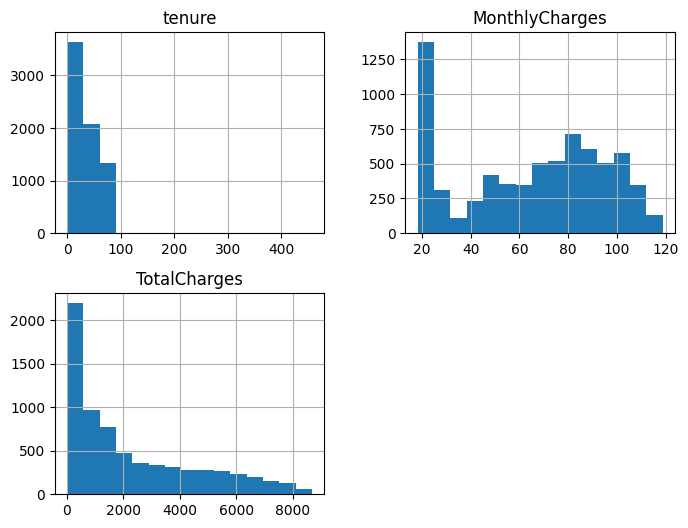

In [94]:
num_df.hist(bins=15, figsize=(8, 6))
plt.show()

Let's check the unique value count per each categorical variables

In [95]:
cat_df = df.select(categorical_cols).toPandas()
for column in cat_df.columns:
  print("{} :".format(column), cat_df[column].unique())

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : ['No' 'Yes']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


Let's find number of null values in all of our dataframe columns

In [96]:
for column in cat_df.columns:
  print("null values of {} :".format(column), cat_df[column].isnull().sum())

null values of customerID : 0
null values of gender : 0
null values of SeniorCitizen : 0
null values of Partner : 0
null values of Dependents : 0
null values of PhoneService : 0
null values of MultipleLines : 0
null values of InternetService : 0
null values of OnlineSecurity : 0
null values of OnlineBackup : 0
null values of DeviceProtection : 0
null values of TechSupport : 0
null values of StreamingTV : 0
null values of StreamingMovies : 0
null values of Contract : 0
null values of PaperlessBilling : 0
null values of PaymentMethod : 0
null values of Churn : 0


In [97]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

**Spark SQL Queries**

In [98]:
df.select(count(when(col('Churn').isNull(), 'Churn'))).show()

+-----------------------------------------------+
|count(CASE WHEN (Churn IS NULL) THEN Churn END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [99]:
for column in df.columns:
  df.select(count(when(col(column).isNull(), column))).show()

+---------------------------------------------------------+
|count(CASE WHEN (customerID IS NULL) THEN customerID END)|
+---------------------------------------------------------+
|                                                        0|
+---------------------------------------------------------+

+-------------------------------------------------+
|count(CASE WHEN (gender IS NULL) THEN gender END)|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

+---------------------------------------------------------------+
|count(CASE WHEN (SeniorCitizen IS NULL) THEN SeniorCitizen END)|
+---------------------------------------------------------------+
|                                                              0|
+---------------------------------------------------------------+

+---------------------------------------------------+
|count(CASE WHEN (Partner IS NULL) THEN Partner END)|

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [100]:
missing_cols = ['TotalCharges']

Creating our Imputer

In [101]:
imputer = Imputer(
    inputCols=missing_cols,
    outputCols=['TotalCharges']
).setStrategy("mean")

Use Imputer to fill the missing values

In [102]:
# Fit the imputer to the data and transform
imputed_df = imputer.fit(df).transform(df)
# Overwrite the original DataFrame with the imputed DataFrame
df = imputed_df.select(['TotalCharges'])

imputed_df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

Let's check the missing value counts again

In [103]:
df.select(count(when(col('TotalCharges').isNull(), 'TotalCharges'))).show()

+-------------------------------------------------------------+
|count(CASE WHEN (TotalCharges IS NULL) THEN TotalCharges END)|
+-------------------------------------------------------------+
|                                                            0|
+-------------------------------------------------------------+



In [104]:
df = imputed_df

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [105]:
# Filter rows where Value is greater than 100
filtered_df = df.filter(col("tenure") > 100)

# Show filtered rows
filtered_df.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [106]:
# Drop rows where Value is greater than 100
cleaned_df = df.filter(col("tenure") <= 100)


### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [107]:
# Create a VectorAssembler object
assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="features")

# Transform the DataFrame
df_num_features = assembler.transform(cleaned_df)


**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [108]:
standardScaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
standardScalerModel = standardScaler.fit(df_num_features)
scaled_df = standardScalerModel.transform(df_num_features)

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [109]:
cat_inx = [column +"_inx" for column in categorical_cols]
indexer = StringIndexer(inputCols=categorical_cols, outputCols=cat_inx)
df_cat_inx = indexer.fit(scaled_df).transform(scaled_df)
df_cat_inx.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+--------------+----------+-----------------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|            features|      scaledFea

Let's combine all of our categorifal features in to one feature vector.

In [110]:
cat_inx = cat_inx[1:len(cat_inx)-1]
cat_inx

['gender_inx',
 'SeniorCitizen_inx',
 'Partner_inx',
 'Dependents_inx',
 'PhoneService_inx',
 'MultipleLines_inx',
 'InternetService_inx',
 'OnlineSecurity_inx',
 'OnlineBackup_inx',
 'DeviceProtection_inx',
 'TechSupport_inx',
 'StreamingTV_inx',
 'StreamingMovies_inx',
 'Contract_inx',
 'PaperlessBilling_inx',
 'PaymentMethod_inx']

In [111]:
cat_assembler = VectorAssembler(
    inputCols=cat_inx,
    outputCol="cat_features_inx")

df_cat_features = cat_assembler.transform(df_cat_inx)

Now let's combine categorical and numerical feature vectors.

In [112]:
model_assembler = VectorAssembler(
    inputCols=["scaledFeatures", "cat_features_inx"],
    outputCol="final_feature_vector")

final_df = model_assembler.transform(df_cat_features)
final_df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+--------------+----------+-----------------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|

In [113]:
input_data = final_df.select("final_feature_vector","Churn_inx")

In [24]:
pd_input = input_data.toPandas()
pd_input.Churn_inx.count()

7042

In [25]:
# Create the count plot
fig = px.histogram(pd_input, x="Churn_inx", title='Count Plot of Categories', facet_col="Churn_inx")
fig.show()

**An unbalanced dataset ⬛**

### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [19]:
train, test = input_data.randomSplit([0.8, 0.2], seed=79)

In [20]:
train.count() , test.count()

(5544, 1498)

In [28]:
train.where(train.Churn_inx == 1).count()

1453

In [29]:
test.where(test.Churn_inx == 1).count()

416

Now let's create and train our desicion tree

In [21]:
dt_class = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_inx', maxDepth=7)
dt_model = dt_class.fit(train)

Let's make predictions on our test data

In [22]:
Prediction_dt_Model = dt_model.transform(test)


### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [23]:
bce = BinaryClassificationEvaluator(labelCol="Churn_inx")
auc_test = bce.evaluate(Prediction_dt_Model, {bce.metricName: "areaUnderROC"})
print("AUC for test set:", auc_test)

AUC for test set: 0.7768955282240865


Let's get the AUC for our `training` set

In [24]:
train_preds = dt_model.transform(train)
auc_train = bce.evaluate(train_preds, {bce.metricName: "areaUnderROC"})
print("AUC for training set:", auc_train)

AUC for training set: 0.7878634432120062


**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [25]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = "Churn_inx", maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_inx")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_inx")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [26]:
depths = [6,7,8,9,11,15]
test_accuracies, train_accuracies = evaluate_dt(depths)

Let's visualize our results

In [27]:
results = pd.DataFrame({
    'Max Depth': depths,
    'Test AUC': test_accuracies,
    'Train AUC': train_accuracies
})
results

,Max Depth,Test AUC,Train AUC
0,6,0.759455,0.768510
1,7,0.776896,0.787863
2,8,0.757444,0.778726
3,9,0.729112,0.776451
4,11,0.768058,0.858525
5,15,0.723123,0.963562


**Logistic Regression**

In [29]:
from pyspark.ml.classification import LogisticRegression

In [32]:
log_reg = LogisticRegression(featuresCol = 'final_feature_vector', labelCol = 'Churn_inx',regParam=.001,elasticNetParam=0.95,maxIter=50)
lg_model = log_reg.fit(train)

predictions =lg_model.transform(test)

In [33]:
# calculating test error
evaluator = BinaryClassificationEvaluator(labelCol="Churn_inx")
auc_test2 = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
# recording the accuracy
print("test: ",auc_test2)

# calculating training error
predictions_training = lg_model.transform(train)
evaluator = BinaryClassificationEvaluator(labelCol="Churn_inx")
auc_training2 = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
print("training: ", auc_training2)

test:  0.8468303444475999
training:  0.8417210289721615


**XGBoost Model**

In [44]:
!pip install xgboost

In [54]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [70]:
def evaluate_xgb(model_params):

  test_aucs = []
  train_aucs = []

  for param_dict in model_params:
    # Create XGBoost model with current parameters
    xgb_model = SparkXGBClassifier(
        features_col="final_feature_vector",
        label_col="Churn_inx",
        # **param_dict  # Unpack hyperparameters from dictionary
    )

    # Train the model
    xgb_model = xgb_model.fit(train)

    # Calculate test AUC
    predictions_test = xgb_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol="Churn_inx")
    auc_test = evaluator.evaluate(predictions_test)
    test_aucs.append(auc_test)

    # Calculate training AUC
    predictions_training = xgb_model.transform(train)
    evaluator = MulticlassClassificationEvaluator(labelCol="Churn_inx")
    auc_training = evaluator.evaluate(predictions_training)
    train_aucs.append(auc_training)

  return test_aucs, train_aucs


In [71]:
model_params = [
    {'max_depth': 3, 'eta': 0.1, 'objective': 'binary:logistic'},
    {'max_depth': 5, 'eta': 0.2, 'objective': 'binary:logistic'},
    {'max_depth': 7, 'eta': 0.3, 'objective': 'binary:logistic'}
]

In [72]:
evaluate_xgb(model_params)

INFO:XGBoost-PySpark:Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


([0.7661615288575795, 0.7661615288575795, 0.7661615288575795],
 [0.9415249251139713, 0.9415249251139713, 0.9415249251139713])

**Random Forest Classifier Model**

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Churn_inx",
                            featuresCol="final_feature_vector", numTrees=81, seed=42, maxDepth=16, )

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[rf])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Churn_inx", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy = %", (accuracy*100))

accuracy = % 77.90387182910547


# **More Feature Engineering and Modelling**

In [114]:
cleaned_df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

In [115]:
from pyspark.sql import functions as F

def replace_categorical_values(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'Yes', 1)
      .otherwise(0))


# Example usage:
df_1 = replace_categorical_values(cleaned_df, 'MultipleLines')

In [116]:
def replace_categorical_values1(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'No', 0)
      .otherwise(1))


# Example usage:
df_1 = replace_categorical_values1(df_1, 'InternetService')

In [118]:
def replace_categorical_values2(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'No', 0)
      .otherwise(1))


# Example usage:
df_1 = replace_categorical_values2(df_1, 'SeniorCitizen')
df_1 = replace_categorical_values2(df_1, 'Partner')
df_1 = replace_categorical_values2(df_1, 'Dependents')
df_1 = replace_categorical_values2(df_1, 'PhoneService')
df_1 = replace_categorical_values2(df_1, 'PaperlessBilling')
df_1.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            1|      1|         1|     1|           

In [119]:
def replace_categorical_values3(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'Female', 0)
      .otherwise(1))


# Example usage:
df_1 = replace_categorical_values3(df_1, 'gender')

In [120]:
def replace_categorical_values4(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'Yes', 1)
      .otherwise(0))


# Example usage:
df_1 = replace_categorical_values4(df_1, 'OnlineSecurity')
df_1 = replace_categorical_values4(df_1, 'OnlineBackup')
df_1 = replace_categorical_values4(df_1, 'DeviceProtection')
df_1 = replace_categorical_values4(df_1, 'TechSupport')
df_1 = replace_categorical_values4(df_1, 'StreamingTV')
df_1 = replace_categorical_values4(df_1, 'StreamingMovies')
df_1 = replace_categorical_values4(df_1, 'Churn')

In [121]:
def replace_categorical_values5(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'One year', 1).when(F.col(column_name) == 'Two year', 2).otherwise(0)
      )
df_1 = replace_categorical_values5(df_1, 'Contract')

In [122]:
def replace_categorical_values6(df, column_name):
  return df.withColumn(
      column_name,
      F.when(F.col(column_name) == 'Electronic check', 1).when(F.col(column_name) == 'Mailed check', 2)
      .when(F.col(column_name) == 'Bank transfer (automatic)', 3).otherwise(0)
      )
df_1 = replace_categorical_values6(df_1, 'PaymentMethod')

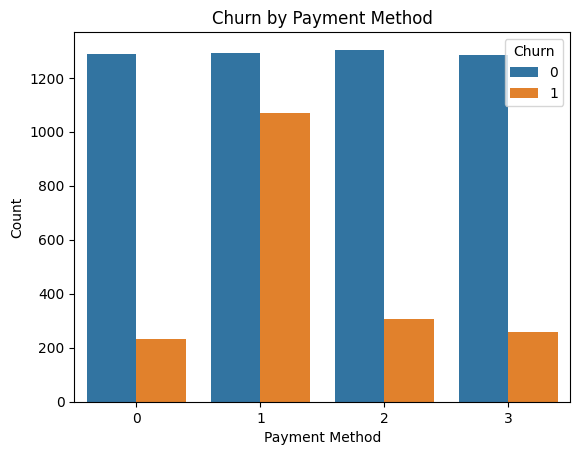

In [51]:
import seaborn as sns

def plot_churn_by_payment_method(df):
  # Convert to Pandas DataFrame
  pandas_df = df.toPandas()

  # Create the count plot
  sns.countplot(x='PaymentMethod', hue='Churn', data=pandas_df)
  plt.title('Churn by Payment Method')
  plt.xlabel('Payment Method')
  plt.ylabel('Count')
  plt.show()

# Example usage:
plot_churn_by_payment_method(df_1)


In [123]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

def one_hot_encode_payment_method(df, column_name):
  encoder = OneHotEncoder(inputCol=column_name, outputCol=column_name + "_vec")
  encoded = encoder.fit(df).transform(df)
  encoded = encoded.drop(column_name)

  return encoded

# Example usage:
df = one_hot_encode_payment_method(df_1, 'PaymentMethod')
df = one_hot_encode_payment_method(df, 'Contract')
df.show()


+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|PaperlessBilling|MonthlyCharges|TotalCharges|Churn|PaymentMethod_vec| Contract_vec|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------------+-------------+
|7590-VHVEG|     0|            1|      1|         1|     1|           1|            0|              1|             0|           1|               0|          0|          0|              0|

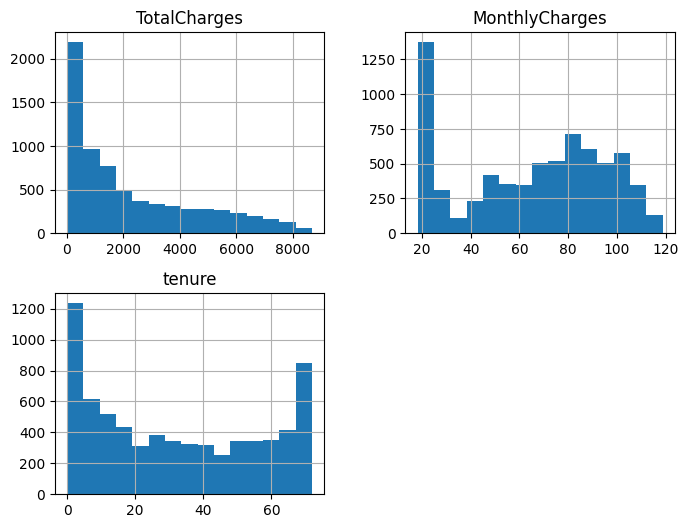

In [123]:
nums = ['TotalCharges', 'MonthlyCharges', 'tenure']
num_df = df.select(nums).toPandas()
num_df.hist(bins=15, figsize=(8, 6))
plt.show()

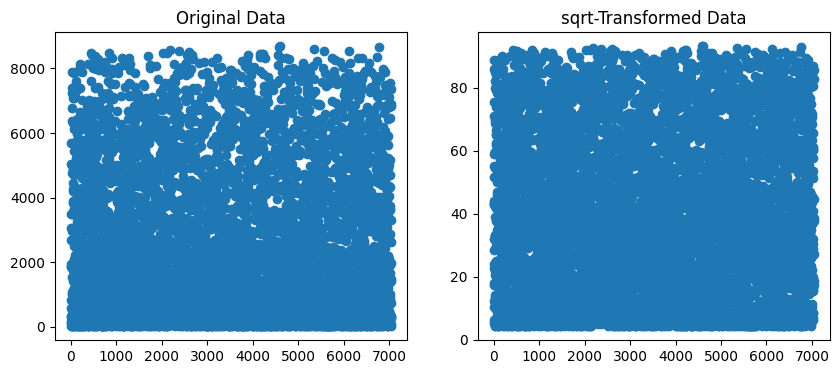

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
original_data = num_df.TotalCharges.values

# Apply transformation
sqrt_transformed_data = np.sqrt(original_data)

# Plot original and transformed data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(range(len(original_data)), original_data)
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.scatter(range(len(sqrt_transformed_data)), sqrt_transformed_data)
plt.title('sqrt-Transformed Data')

plt.show()

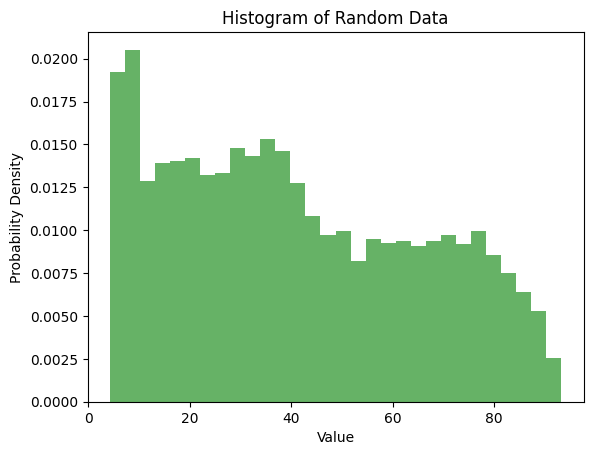

In [125]:
plt.hist( sqrt_transformed_data, bins=30, density=True, alpha=0.6, color='g')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of Random Data')

plt.show()

In [124]:
from pyspark.sql import functions as F

# applying square root function
df = df.withColumn("sqrt_TotalCharges", F.sqrt(df["TotalCharges"]))


In [238]:
new_num = ['tenure', 'MonthlyCharges', 'sqrt_TotalCharges']


In [126]:
# Create a VectorAssembler object
assembler = VectorAssembler(
    inputCols=new_num,
    outputCol="features")

# Transform the DataFrame
df_num_features = assembler.transform(df)

standardScaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
standardScalerModel = standardScaler.fit(df_num_features)
scaled_df = standardScalerModel.transform(df_num_features)
scaled_df.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------------+-------------+------------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|PaperlessBilling|MonthlyCharges|TotalCharges|Churn|PaymentMethod_vec| Contract_vec| sqrt_TotalCharges|            features|      scaledFeatures|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------------+-------------+------------------+--------------------+--------------------+
|759

In [127]:
cat = ['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod_vec',
 'Contract_vec' ]

In [128]:
cat_assembler = VectorAssembler(
    inputCols=cat,
    outputCol="cat_features")


In [129]:
df_cat_features = cat_assembler.transform(scaled_df)


In [130]:
model_assembler = VectorAssembler(
    inputCols=["scaledFeatures", "cat_features"],
    outputCol="final_feature_vector")

final_df = model_assembler.transform(df_cat_features)


In [63]:
fe_input_data = final_df.select("final_feature_vector","Churn")

In [64]:
fe_train, fe_test = fe_input_data.randomSplit([0.8, 0.2], seed=79)
fe_train.count() , fe_test.count()


(5544, 1498)

In [65]:
log_reg2 = LogisticRegression(featuresCol = 'final_feature_vector', labelCol = 'Churn',regParam=.001,elasticNetParam=0.95,maxIter=50)
lg_model2 = log_reg2.fit(fe_train)

predictions =lg_model2.transform(fe_test)
# calculating test error
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
auc_test2 = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
# recording the accuracy
print("test: ",auc_test2)

# calculating training error
predictions_training = lg_model2.transform(fe_train)
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
auc_training2 = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
print("training: ", auc_training2)

test:  0.8186307557098156
training:  0.855798438167369


# **Resampling Technique Fixing Imbalanced Data**


*   **Resampling to fix imbalanced data**



* Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.





**We will transform to pandas dataframe to use the SMOTENN technique then get back again to PySpark dataframe**

In [173]:
ff = final_df.toPandas()

In [176]:
df['Churn'] = ff['Churn']
df.head(5)

,column 0,column 1,column 2,column 3,column 4,column 5,column 6,column 7,column 8,column 9,...,column 13,column 14,column 15,column 16,column 17,column 18,column 19,column 20,column 21,Churn
0,0.040719,0.991961,0.222784,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,1.384436,1.892535,1.772498,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
2,0.081437,1.789517,0.424058,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
3,1.832342,1.405693,1.749483,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
4,0.081437,2.349468,0.502150,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1


In [153]:
ff.final_feature_vector[150]

DenseVector([0.285, 3.157, 1.044, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0])

In [159]:
df = pd.concat([pd.Series(x.toArray()) for x in ff.final_feature_vector], axis=1).T


In [164]:
df.columns = ['column ' + str(i) for i in range(len(df.columns))]

In [203]:
from imblearn.combine import SMOTEENN

def apply_smote(df, target_col):
  # Separate features and target variable
  X = df.drop(target_col, axis=1)
  y = df[target_col]

  # Apply SMOTE
  sm = SMOTEENN(random_state=42)
  X_res, y_res = sm.fit_resample(X, y)

  # Convert back to PySpark DataFrame
  balanced_df = spark.createDataFrame(pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1))

  return balanced_df


In [204]:
balanced_df = apply_smote(df, 'Churn')

In [205]:
balanced_df.show()

+-------------------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-----+
|           column 0|          column 1|          column 2|column 3|column 4|column 5|column 6|column 7|column 8|column 9|column 10|column 11|column 12|column 13|column 14|column 15|column 16|column 17|column 18|column 19|column 20|column 21|Churn|
+-------------------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-----+
| 1.3844363912719098|1.8925345014311106|1.7724982172902988|     1.0|     1.0|     1.0|     1.0|     1.0|     0.0|     1.0|      1.0|      0.0|      1.0|      0.0|      0.0|      0.0|      1.0|      0.0|      0.0|      1.0|      0.0|      1.0|    0|
|  1

In [209]:
in_list= balanced_df.columns[0:len(balanced_df.columns)-1]

In [214]:
model_assembler = VectorAssembler(
    inputCols=in_list,
    outputCol="allfeatures")

final_balanced = model_assembler.transform(balanced_df)


In [217]:
balance = final_balanced.select("allfeatures","Churn")
b_train, b_test = balance.randomSplit([0.85, 0.15], seed=79)
b_train.count() , b_test.count()


(5312, 989)

In [220]:
b_log_reg = LogisticRegression(featuresCol = 'allfeatures', labelCol = 'Churn',regParam=.001,elasticNetParam=0.01,maxIter=100)
b_lg_model = b_log_reg.fit(b_train)

predictions = b_lg_model.transform(b_test)
# calculating test error
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
auc_test2 = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
# recording the accuracy
print("test: ",auc_test2)

# calculating training error
predictions_training = b_lg_model.transform(b_train)
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
auc_training2 = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
print("training: ", auc_training2)

test:  0.9710593047034778
training:  0.9668623011020262


In [224]:
def b_evaluate_dt(mode_params,train,test):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'allfeatures', labelCol = "Churn", maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

In [226]:
depths = [5,7,9,11,15]
test_accuracies, train_accuracies = b_evaluate_dt(depths,b_train,b_test)
results = pd.DataFrame({
    'Max Depth': depths,
    'Test AUC': test_accuracies,
    'Train AUC': train_accuracies
})
results

,Max Depth,Test AUC,Train AUC
0,5,0.947573,0.949564
1,7,0.967738,0.970548
2,9,0.973501,0.983015
3,11,0.970969,0.991468
4,15,0.973491,0.998053


In [229]:
from pyspark.ml.classification import GBTClassifier

In [230]:

def b_evaluate_gbt(mode_params, train, test):

  test_accuracies = []
  train_accuracies = []

  for maxD in mode_params:
    # Train the model with GBTClassifier
    gbt = GBTClassifier(featuresCol="allfeatures", labelCol="Churn",
                        maxDepth=maxD, maxIter=30, seed=42)

    gbt_model = gbt.fit(train)

    # Calculate test accuracy
    predictions_test = gbt_model.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol="Churn")
    auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
    test_accuracies.append(auc_test)

    # Calculate training accuracy
    predictions_training = gbt_model.transform(train)
    evaluator = BinaryClassificationEvaluator(labelCol="Churn")
    auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
    train_accuracies.append(auc_training)

  return test_accuracies, train_accuracies


In [231]:
depths = [5,7,9,11,15]
test_accuracies, train_accuracies = b_evaluate_gbt(depths,b_train,b_test)
results = pd.DataFrame({
    'Max Depth': depths,
    'Test AUC': test_accuracies,
    'Train AUC': train_accuracies
})
results

,Max Depth,Test AUC,Train AUC
0,5,0.987313,0.991362
1,7,0.989926,0.998035
2,9,0.990748,0.999661
3,11,0.985626,0.999977
4,15,0.975399,0.999978


# **7 - Model Deployment**

**This code was used with Decision Tree Classifier Model**

- Giving Recommendations using our model

In [234]:
gbt = GBTClassifier(featuresCol="allfeatures", labelCol="Churn",
                        maxDepth=9, maxIter=20, seed=42)

gbt_model = gbt.fit(b_train)



We were asked to recommend a solution to reduce the customer churn.


In [239]:
# Assuming "model" is Decision Tree Classifier Model
importances = gbt_model.featureImportances
# Get input column names from the assembler (numerical + categorical in the same oreder of assembler)
input_cols = new_num + cat

# Create a DataFrame for feature importances
importances_df = pd.DataFrame(list(zip(input_cols, importances)), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [240]:
importances_df

,Feature,Importance
1,MonthlyCharges,0.102239
0,tenure,0.085298
9,InternetService,0.050930
2,sqrt_TotalCharges,0.047255
15,StreamingMovies,0.035067
3,gender,0.034666
13,TechSupport,0.032372
10,OnlineSecurity,0.029257
11,OnlineBackup,0.025404
17,PaymentMethod_vec,0.024767


In [241]:

px.bar(importances_df, x=importances_df.Feature, y='Importance')


In [247]:
dataframe = final_df.toPandas()

In [248]:
dataframe.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'PaymentMethod_vec', 'Contract_vec',
       'sqrt_TotalCharges', 'features', 'scaledFeatures', 'cat_features',
       'final_feature_vector'],
      dtype='object')

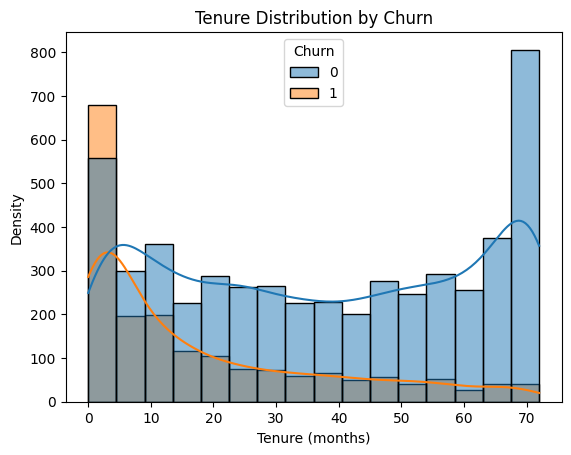

In [250]:
sns.histplot(data=dataframe, x='tenure', hue='Churn', kde=True)
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (months)')
plt.ylabel('Density')
plt.show()

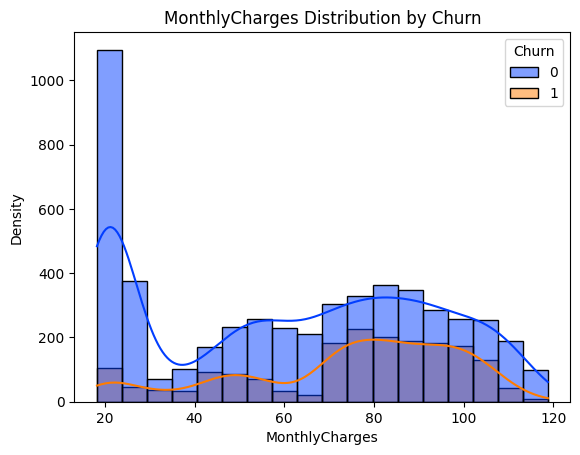

In [252]:
sns.histplot(data=dataframe, x='MonthlyCharges', hue='Churn', kde=True, palette='bright')
plt.title('MonthlyCharges Distribution by Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.show()

Let's create a bar chart to visualize the customer churn per contract type

The bar chart displays that monthly charges and tenure, internet service have the most effective influence on churn rates. As a recommendation, the telecommunication company could consider offering subscriptions or discounts for long-term clients to encourage customers with lower tenure (less than 20 months).

Also, you should encourage or motivate the new clients less that 20 months tenure with offers and deals to maintain them.